In [99]:
# https://www.cs.toronto.edu/~lczhang/321/lec/rnn_notes.html

import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt
import torchtext

In [100]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [101]:
def get_data(file):
    # This is a very large file, so we will not load it into RAM
    return csv.reader(open(file, "rt", encoding="latin-1"))

def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ") \
                 .replace("@", " @ ") \
                 .replace("#", " # ") \
                 .replace("$", " $ ")
    return tweet.lower().split()

In [102]:
DIMENSION_SIZE=50
glove = torchtext.vocab.GloVe(name="6B", dim=DIMENSION_SIZE)

In [103]:
def get_tweet_words(glove_vector):
    train, valid, test = [], [], []
    for i, line in enumerate(get_data("../data/training.1600000.processed.noemoticon.csv")):
        tweet = line[-1]
        idxs = [glove_vector.stoi[w]        # lookup the index of word
                for w in split_tweet(tweet)
                if w in glove_vector.stoi] # keep words that has an embedding
        if not idxs: # ignore tweets without any word with an embedding
            continue
        idxs = torch.tensor(idxs) # convert list to pytorch tensor
        label = torch.tensor(int(line[0] == "4")).long()
        if i % 5 < 3:
            train.append((idxs, label))
        elif i % 5 == 4:
            valid.append((idxs, label))
        else:
            test.append((idxs, label))
    return train, valid, test

train, valid, test = get_tweet_words(glove)

In [104]:
example_tweet = train[0][0]

glove_emb = nn.Embedding.from_pretrained(glove.vectors)
example_tweet_emb = glove_emb(example_tweet)

print(example_tweet.shape)
print(example_tweet_emb.shape)

torch.Size([23])
torch.Size([23, 50])


In [105]:
class RnnSentimentClf(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_rnn_stacks=1, dropout=0):
        super(RnnSentimentClf, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, num_layers=num_rnn_stacks, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Forward propagate the RNN
        out, _ = self.rnn(x)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [106]:
class LstmSentimentClf(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_rnn_stacks=1, dropout=0):
        super(LstmSentimentClf, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=num_rnn_stacks, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [107]:
class GruSentimentClf(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_rnn_stacks=1, dropout=0):
        super(GruSentimentClf, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=num_rnn_stacks, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Forward propagate the GRU 
        out, _ = self.rnn(x)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [108]:
import random
random.seed(1)

class TweetBatcher:
    def __init__(self, tweets, batch_size=32, drop_last=False):
        # store tweets by length
        self.tweets_by_length = {}
        for words, label in tweets:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)
         
        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, tweets in self.tweets_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)


In [109]:
for i, (tweets, labels) in enumerate(TweetBatcher(train, drop_last=False)):
    if i > 5: break
    print(tweets.shape, labels.shape)

torch.Size([32, 25]) torch.Size([32])
torch.Size([4, 74]) torch.Size([4])
torch.Size([32, 20]) torch.Size([32])
torch.Size([32, 1]) torch.Size([32])
torch.Size([32, 19]) torch.Size([32])
torch.Size([5, 80]) torch.Size([5])


In [110]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        tweets = tweets.to(device)
        labels = labels.to(device)
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

In [111]:
train_loader = TweetBatcher(train, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=64, drop_last=False)
test_loader = TweetBatcher(test, batch_size=64, drop_last=False)

In [112]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        print("Epoch #{}".format(epoch))
        for tweets, labels in train:
            
            tweets = tweets.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [114]:
model = RnnSentimentClf(input_size=DIMENSION_SIZE, hidden_size=DIMENSION_SIZE, num_classes=2).to(device)
# train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-4)
# get_accuracy(model, test_loader)

In [138]:
texts = ["I hate every single minute of this day.", "I love everybody lol"]
texts = [split_tweet(text) for text in texts]
print(texts)
idxs = []
for text in texts:
    idxs.append([glove.stoi[w] for w in text if w in glove.stoi]) # keep words that has an embedding
print(idxs)
max_size = max(len(text) for text in texts)
print(max_size)

for i in range(len(idxs)):
    # print(idxs[i])
    list = idxs[i]
    for j in range(len(list), max_size):
        list.append(glove.stoi['.'])

idxs = torch.tensor(idxs).to(device)
# idxs = torch.unsqueeze(idxs, dim=0)
print(idxs)
out = model(idxs)
pred = out.max(1, keepdim=True)[1]
print(idxs, pred)

[['i', 'hate', 'every', 'single', 'minute', 'of', 'this', 'day', '.'], ['i', 'love', 'everybody', 'lol']]
[[41, 5281, 359, 592, 1214, 3, 37, 122, 2], [41, 835, 2587, 73048]]
9
tensor([[   41,  5281,   359,   592,  1214,     3,    37,   122,     2],
        [   41,   835,  2587, 73048,     2,     2,     2,     2,     2]])
tensor([[   41,  5281,   359,   592,  1214,     3,    37,   122,     2],
        [   41,   835,  2587, 73048,     2,     2,     2,     2,     2]]) tensor([[1],
        [1]])


Epoch #0
Epoch 1; Loss 0.454743; Train Acc 0.748779; Val Acc 0.748513
Epoch #1
Epoch 2; Loss 0.410354; Train Acc 0.761630; Val Acc 0.760533
Epoch #2
Epoch 3; Loss 0.532462; Train Acc 0.771138; Val Acc 0.769741
Epoch #3
Epoch 4; Loss 0.410168; Train Acc 0.773782; Val Acc 0.771412
Epoch #4
Epoch 5; Loss 0.426891; Train Acc 0.779504; Val Acc 0.776899
Epoch #5
Epoch 6; Loss 0.357840; Train Acc 0.779281; Val Acc 0.776230
Epoch #6
Epoch 7; Loss 0.443313; Train Acc 0.786297; Val Acc 0.783516
Epoch #7
Epoch 8; Loss 0.425472; Train Acc 0.788904; Val Acc 0.784887
Epoch #8
Epoch 9; Loss 0.307940; Train Acc 0.790470; Val Acc 0.786986
Epoch #9
Epoch 10; Loss 0.470025; Train Acc 0.791054; Val Acc 0.787080
Epoch #10
Epoch 11; Loss 0.362282; Train Acc 0.793304; Val Acc 0.789242
Epoch #11
Epoch 12; Loss 0.379990; Train Acc 0.793936; Val Acc 0.789980
Epoch #12
Epoch 13; Loss 0.388840; Train Acc 0.791422; Val Acc 0.787315
Epoch #13
Epoch 14; Loss 0.364175; Train Acc 0.794559; Val Acc 0.789943
Epoch #14
E

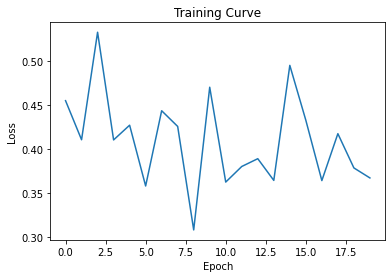

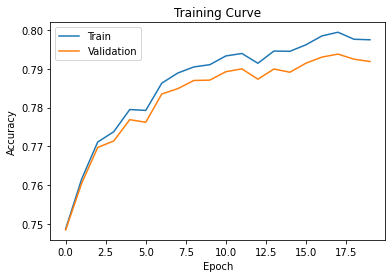

0.7927130293862764

In [ ]:
model = GruSentimentClf(input_size=DIMENSION_SIZE, hidden_size=DIMENSION_SIZE, num_classes=2).to(device)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-4)
get_accuracy(model, test_loader)

Epoch #0
Epoch 1; Loss 0.403117; Train Acc 0.748730; Val Acc 0.747947
Epoch #1
Epoch 2; Loss 0.415934; Train Acc 0.761196; Val Acc 0.759854
Epoch #2
Epoch 3; Loss 0.519390; Train Acc 0.759461; Val Acc 0.757455
Epoch #3
Epoch 4; Loss 0.439396; Train Acc 0.774276; Val Acc 0.772979
Epoch #4
Epoch 5; Loss 0.352561; Train Acc 0.772054; Val Acc 0.770927
Epoch #5
Epoch 6; Loss 0.384331; Train Acc 0.785540; Val Acc 0.783282
Epoch #6
Epoch 7; Loss 0.307683; Train Acc 0.788188; Val Acc 0.785925
Epoch #7
Epoch 8; Loss 0.571063; Train Acc 0.788419; Val Acc 0.786326
Epoch #8
Epoch 9; Loss 0.387900; Train Acc 0.790960; Val Acc 0.787950
Epoch #9
Epoch 10; Loss 0.443339; Train Acc 0.794732; Val Acc 0.791488
Epoch #10
Epoch 11; Loss 0.291350; Train Acc 0.789063; Val Acc 0.785356
Epoch #11
Epoch 12; Loss 0.389129; Train Acc 0.795734; Val Acc 0.791801
Epoch #12
Epoch 13; Loss 0.435239; Train Acc 0.799206; Val Acc 0.794548
Epoch #13
Epoch 14; Loss 0.341750; Train Acc 0.799213; Val Acc 0.794332
Epoch #14
E

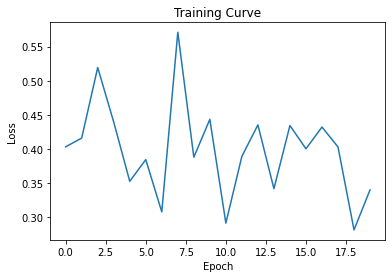

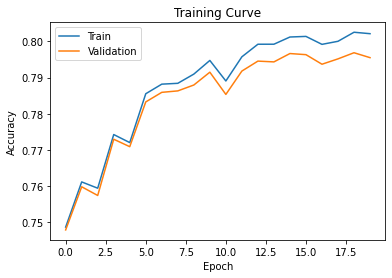

0.7962701672824656

In [ ]:
model = LstmSentimentClf(input_size=DIMENSION_SIZE, hidden_size=DIMENSION_SIZE, num_classes=2).to(device)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-4)
get_accuracy(model, test_loader)